In [36]:
import os
import speech_recognition as sr
import librosa
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from itertools import cycle
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping
import tensorflow as tf
tf.get_logger().setLevel('INFO')
from tensorflow import keras

from keras.utils.np_utils import to_categorical

### Import Audio

In [3]:
data_path = os.path.abspath('../data/voice')
data = pd.read_csv(data_path + '/audio_store.csv')

In [4]:
data.head()

,id,audio_file,transcript,name,command,passive_active
0,20230302103237,20230302103237_voice.wav,the sweet scent of a rose is simply in chanting,Travis,NaN,Passive
1,20230302103336,20230302103336_voice.wav,autonomous agents such as robots and drones ha...,Travis,NaN,Passive
2,20230304194200,20230304194200_voice.wav,the ship sailed gracefully across the calm sea,Eric,NaN,Passive
3,20230304194616,20230304194616_voice.wav,the Tangier taste of grapefruit is a refreshin...,Eric,NaN,Passive
4,20230304194829,20230304194829_voice.wav,Lion King tells the story of a young lion cub ...,Eric,NaN,Passive


In [5]:
any(data['id'].duplicated())  # Check for any duplicate ID's

False

## Access Audio Recordings
Utilize the file names in each row of the dataframe in order to generate a librosa audio array. This array allows for calculation of the audio duration, and will enable the modelling process

In [6]:
def generate_librosa_audio(x):
    y, sr = librosa.load(data_path + "/" + x)
    return y

def determine_recording_duration(x):
    return librosa.get_duration(y=x)

data['audio_librosa'] = data['audio_file'].map(generate_librosa_audio)  # Generate Librosa audio objects
data['duration'] = data['audio_librosa'].map(determine_recording_duration)  # Determine duration of all voice samples

In [7]:
data['id'] = data['id'].apply(str)  # Convert id column to string
data.head()

,id,audio_file,transcript,name,command,passive_active,audio_librosa,duration
0,20230302103237,20230302103237_voice.wav,the sweet scent of a rose is simply in chanting,Travis,NaN,Passive,"[0.0007299095, 0.0012379286, 0.0010190066, 0.0...",7.360726
1,20230302103336,20230302103336_voice.wav,autonomous agents such as robots and drones ha...,Travis,NaN,Passive,"[0.0009884, 0.00145748, 0.0011613376, 0.000781...",27.910385
2,20230304194200,20230304194200_voice.wav,the ship sailed gracefully across the calm sea,Eric,NaN,Passive,"[-0.0006241321, -0.000798404, -0.00074554444, ...",4.565351
3,20230304194616,20230304194616_voice.wav,the Tangier taste of grapefruit is a refreshin...,Eric,NaN,Passive,"[-0.003800225, -0.0057664965, -0.0050742594, -...",4.949342
4,20230304194829,20230304194829_voice.wav,Lion King tells the story of a young lion cub ...,Eric,NaN,Passive,"[0.00015238849, 0.0002599604, 0.00023779337, 0...",92.160000


## Dataset Characteristics

In [8]:
# Recording id is comprised of the date time it was created. 
# Create datatime object to show case data over time.
data['date_time'] = pd.to_datetime(data['id'], format='%Y%m%d%H%M%S')

# Visualize User Audio Recordings

In [20]:
def data_before(date, df):
    query = "date_time <= " + date
    filtered_df = df.query(query)
    return filtered_df

def user_recording_sum(filtered_data):
    user_data = filtered_data.groupby(by=['name']).agg({'duration': 'sum'})
    return user_data.reset_index()

## Get recordings done before 2023-03-20
current_date = '20230320'  # Date 2023-03-20
collected_data = data_before(current_date, data)  # Retrieve recordings from before/ on the date
user_recordings = user_recording_sum(collected_data)  # Calculate recording durations sum for each user

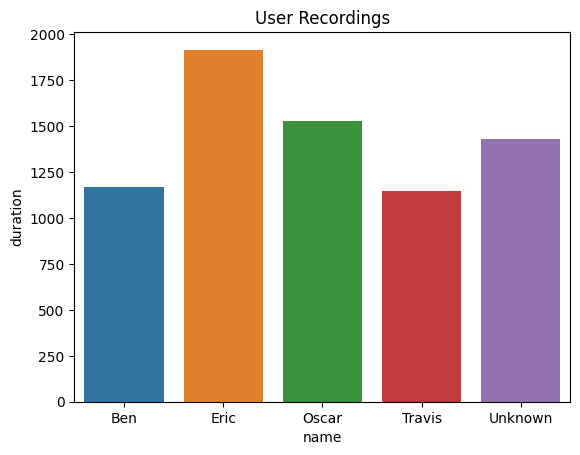

In [21]:
sns.barplot(data=user_recordings, x="name", y='duration')
plt.title('User Recordings')
plt.show()

## Voice Classiciation Model 

### Feature Extraction
Feature Extraction will focus on transforming the audio recording of each individual into a feature vector. This feature vector has a paired speaker label, which can then be trained upon using a deep neural network. The below represent a set of possibilities to generate the audio feature vecotr based on previous projects completed by: https://github.com/jurgenarias/Portfolio/tree/master/Voice%20Classification. Due to the limited number of users currently, the Mel Spectrogram is used. If the user base grows and further audio information is required to distinguish users, then the possibilities below are to be explored.

**Features Possibilities include:**
- Mel Spectrogram
- Mel-frequency Cepstral Coefficients (MFCC's)
- Short-time Fourier Transform (STFT)
- Spectral Constrast
- Chromagram
- Tonal Centroids


### Mel Spectrogram Example

Samples were visualized from inspiration of Librosa docs: https://librosa.org/doc/main/generated/librosa.feature.mfcc.html

In [23]:
sample_recording = data['audio_librosa'][10]  # Read in audio sample

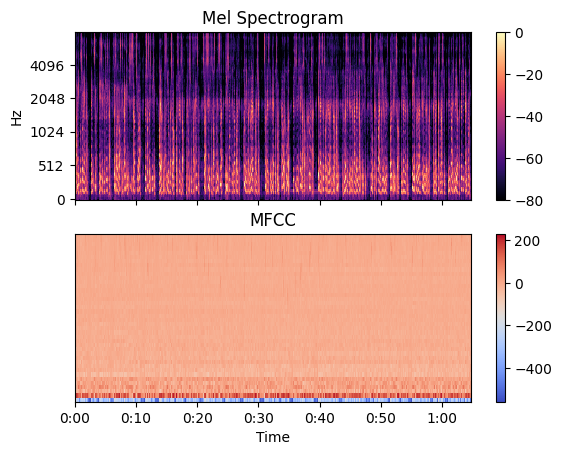

In [24]:
mel_spectrogram = librosa.feature.melspectrogram(y=sample_recording, n_mels=128, fmax=8000)  # Compute the mel spectrogram

mfcc = librosa.feature.mfcc(y=sample_recording, n_mfcc=40)  # Generate mfcc

fig, ax = plt.subplots(nrows=2, sharex=True)

# Mel Spectrogram Visualization
mel_spect_image = librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max),
                                          x_axis='time', y_axis='mel', fmax=8000, ax=ax[0])
fig.colorbar(mel_spect_image, ax=[ax[0]])
ax[0].set(title='Mel Spectrogram')
ax[0].label_outer()

# MFCC Visualization
mfcc_image = librosa.display.specshow(mfcc, x_axis='time', ax=ax[1])
fig.colorbar(mfcc_image, ax=[ax[1]])
ax[1].set(title='MFCC')
ax[1].label_outer()

### Feature Extraction Walkthrough

**1. Gather audio recording to be transformed into a feature vector**

In [25]:
sample_recording = data['audio_librosa'][19]  # Gather audio recording

**2. Generate a Mel Spectrogram of the audio recording**
A Mel Spectrogram is utilized extensively in order to train Neural Networks on audio data. 

A normal spectrogram, utilizes the Fourier transform into order to determine the audio frequencies accross the time series of the audio recording. However, humans perceive sounds logarithmically, hence, a Mel Spectrogram transforms the frequencies into the Mel Scale (logarithmic scale). The Mel scale is comprised of Mel bands representative of frequency bins (default Mel bands used is 128). 

In [26]:
mel_spec = librosa.feature.melspectrogram(y=sample_recording, sr=22050)  # Generate mel spectrogram

**3. Convert mel spectrogram into a dataframe**

DataFrame rows are considered Mel-bands and columns represent the time series.

In [27]:
mel_df = pd.DataFrame(mel_spec)  # Generate dataframe from mel_db
print('DataFrame shape: ', mel_df.shape)
mel_df.head()

DataFrame shape:  (128, 2070)


,0,1,2,3,4,5,6,7,8,9,...,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069
0,0.000908,0.000641,0.000686,0.000473,0.000173,0.000366,0.000657,0.000915,0.000472,0.000180,...,0.000116,0.000200,0.000067,0.000052,0.000089,0.000229,0.000137,0.000191,0.000304,0.000136
1,0.003772,0.004715,0.001292,0.001762,0.001720,0.002249,0.001292,0.002700,0.001484,0.001716,...,0.000219,0.001178,0.001373,0.000583,0.002386,0.002701,0.000563,0.001878,0.002154,0.000518
2,0.002778,0.001903,0.000515,0.000922,0.001160,0.001350,0.000586,0.000678,0.000971,0.001224,...,0.000772,0.001317,0.001185,0.000789,0.002610,0.002202,0.000931,0.001575,0.000764,0.000490
3,0.001884,0.001689,0.000257,0.000225,0.000865,0.000453,0.000118,0.000219,0.000608,0.001111,...,0.001736,0.001247,0.000416,0.000406,0.000902,0.000693,0.000713,0.000253,0.000240,0.000211
4,0.000474,0.000368,0.000106,0.000111,0.000098,0.000061,0.000044,0.000046,0.000080,0.000039,...,0.000168,0.000081,0.000028,0.000137,0.000232,0.000100,0.000162,0.000142,0.000233,0.000137


**4. Transpose the DataFrame and calculate mean** 

This will make the rows to represent the time series of the voice recording, and the columns to represent the mel bands. 
The mean is then calculated accross the columns (mel bands) in order to generate the mean of each mel band frequency accross the time series. 

This results in a feature vector of size (128)

In [28]:
features = np.mean(mel_df.T, axis=0)  # Transpose dataframe and generate mel band mean
print("Feature shape: ", features.shape)

Feature shape:  (128,)


**5. Convert to Vector**

Convert Series to vector form using the numpy to_vector() method.

### Feature Extraction

In [29]:
def feature_extraction(x):
    mel_spec = librosa.feature.melspectrogram(y=x, sr=22050)  # Generate mel spectrogram
    mel_df = pd.DataFrame(mel_spec)  # Generate dataframe from mel_db
    feature = np.mean(mel_df.T, axis=0)  # Transpose dataframe and generate mel band mean
    return feature.to_numpy()  # Convert to numpy vector
    
    
data['feature_vector'] = data['audio_librosa'].apply(feature_extraction)

In [30]:
data.head()

,id,audio_file,transcript,name,command,passive_active,audio_librosa,duration,date_time,feature_vector
0,20230302103237,20230302103237_voice.wav,the sweet scent of a rose is simply in chanting,Travis,NaN,Passive,"[0.0007299095, 0.0012379286, 0.0010190066, 0.0...",7.360726,2023-03-02 10:32:37,"[0.00034863938, 0.0003950474, 0.00043902823, 0..."
1,20230302103336,20230302103336_voice.wav,autonomous agents such as robots and drones ha...,Travis,NaN,Passive,"[0.0009884, 0.00145748, 0.0011613376, 0.000781...",27.910385,2023-03-02 10:33:36,"[0.00054572994, 0.0005837103, 0.0006416146, 0...."
2,20230304194200,20230304194200_voice.wav,the ship sailed gracefully across the calm sea,Eric,NaN,Passive,"[-0.0006241321, -0.000798404, -0.00074554444, ...",4.565351,2023-03-04 19:42:00,"[0.028684858, 0.15808305, 0.08972754, 1.801636..."
3,20230304194616,20230304194616_voice.wav,the Tangier taste of grapefruit is a refreshin...,Eric,NaN,Passive,"[-0.003800225, -0.0057664965, -0.0050742594, -...",4.949342,2023-03-04 19:46:16,"[0.035017632, 0.17645067, 0.10112672, 1.155559..."
4,20230304194829,20230304194829_voice.wav,Lion King tells the story of a young lion cub ...,Eric,NaN,Passive,"[0.00015238849, 0.0002599604, 0.00023779337, 0...",92.160000,2023-03-04 19:48:29,"[0.16188964, 0.49618632, 0.2668955, 1.0968727,..."


## Train/ Test Data Split

Create the training and test sets for the voice classification model. The testing set will comrpise of 20% of the data.

**1. Generate clean DataFrame containing only feature vector and label (name)**

In [31]:
data_clean = data[['feature_vector', 'name']].copy()
data_clean.head()

,feature_vector,name
0,"[0.00034863938, 0.0003950474, 0.00043902823, 0...",Travis
1,"[0.00054572994, 0.0005837103, 0.0006416146, 0....",Travis
2,"[0.028684858, 0.15808305, 0.08972754, 1.801636...",Eric
3,"[0.035017632, 0.17645067, 0.10112672, 1.155559...",Eric
4,"[0.16188964, 0.49618632, 0.2668955, 1.0968727,...",Eric


**2. Encode speaker labels**

In [32]:
le = preprocessing.LabelEncoder()
data_clean['label'] = pd.Series(le.fit_transform(data_clean['name']))  # Generate labels for each unique user.
print(data_clean.head())  # Display the numerical labels of the users

no_unique_speakers = len(data_clean.name.unique())  #Determine the required output size for the model based on the number of users + unknown

                                      feature_vector    name  label
0  [0.00034863938, 0.0003950474, 0.00043902823, 0...  Travis      3
1  [0.00054572994, 0.0005837103, 0.0006416146, 0....  Travis      3
2  [0.028684858, 0.15808305, 0.08972754, 1.801636...    Eric      1
3  [0.035017632, 0.17645067, 0.10112672, 1.155559...    Eric      1
4  [0.16188964, 0.49618632, 0.2668955, 1.0968727,...    Eric      1


**Note:** The labels are based on alphabetical ordering. Such that the a sample of the labels from the users [Ben, Eric, Oscar, Travis, Unknown] would have the corresponding labels [0, 1, 2, 3, 4]

**3. Create train and test data splits**

In [33]:
train_data, test_data = train_test_split(data_clean, test_size=0.3)

In [34]:
X_train_raw = train_data['feature_vector']
y_train_raw = train_data['label']

X_test_raw = train_data['feature_vector']
y_test_raw = train_data['label']

**4. Convert Columns to Tensor Format**

In [37]:
def tensor_features(X_data_raw, y_data_raw):
    x_expanded = pd.DataFrame(X_data_raw.tolist())  # Expand feature vector into a dataframe
    x_data = tf.convert_to_tensor(x_expanded)  # Convert dataframe to tensor
    
    le = preprocessing.LabelEncoder()  # Create label encoder object
    y_data = to_categorical(le.fit_transform(y_data_raw))  # One-hot-encode labels
    return x_data, y_data

X_train, y_train = tensor_features(X_train_raw, y_train_raw)
print(X_train.shape)
X_test, y_test = tensor_features(X_test_raw, y_test_raw)

(146, 128)


**4. Create Model**
Model specification similar to a similar project that aims to classify 115 individuals. This model has been adapted to the described use-case. 
Reference Link: https://github.com/jurgenarias/Portfolio/tree/master/Voice%20Classification

In [38]:
model = Sequential()

model.add(Dense(128, input_shape=(128,), activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(80, activation = 'relu'))
model.add(Dropout(0.5))  

model.add(Dense(40, activation = 'relu'))
model.add(Dropout(0.5))    

model.add(Dense(no_unique_speakers, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='loss', min_delta=0, patience=50, verbose=1, mode='auto')

**5. Train Model**

In [39]:
model_history = model.fit(X_train, y_train, batch_size=20, epochs=100,
                    callbacks=[early_stop])

Epoch 1/100
8/8 [==============================] - 0s 3ms/step - loss: 11.7844 - accuracy: 0.1438
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 5.5645 - accuracy: 0.2260
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 3.6682 - accuracy: 0.3082
Epoch 4/100
8/8 [==============================] - 0s 1ms/step - loss: 3.1541 - accuracy: 0.3014
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 2.5997 - accuracy: 0.3836
Epoch 6/100
8/8 [==============================] - 0s 1ms/step - loss: 1.9327 - accuracy: 0.4658
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 1.9792 - accuracy: 0.4589
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 1.8857 - accuracy: 0.5274
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 1.3467 - accuracy: 0.5137
Epoch 10/100
8/8 [==============================] - 0s 1ms/step - loss: 1.2641 - accuracy: 0.4658
Epoch 11/100
8/8 [==========

8/8 [==============================] - 0s 3ms/step - loss: 0.2112 - accuracy: 0.9110
Epoch 85/100
8/8 [==============================] - 0s 3ms/step - loss: 0.3503 - accuracy: 0.8973
Epoch 86/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3149 - accuracy: 0.9452
Epoch 87/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2502 - accuracy: 0.8973
Epoch 88/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2024 - accuracy: 0.9521
Epoch 89/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3047 - accuracy: 0.9315
Epoch 90/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1679 - accuracy: 0.9658
Epoch 91/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2211 - accuracy: 0.9315
Epoch 92/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1730 - accuracy: 0.9452
Epoch 93/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1594 - accuracy: 0.9452
Epoch 94/100
8/8 [===============

**6. Model Analysis**

**6.1 Model Training Accuracy**

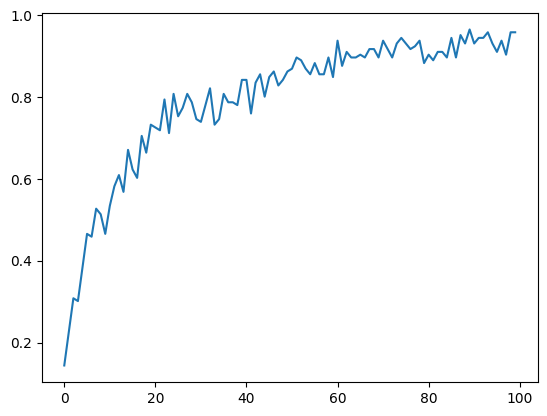

In [40]:
training_accuracy = model_history.history['accuracy']

plt.plot(training_accuracy, label='Training Accuracy')
plt.show()

**6.2 Testing Accuracy**

In [41]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Model Test set Loss: ", score[0])
print('Model Test set Accuracy: ', score[1])

Model Test set Loss:  0.04115522652864456
Model Test set Accuracy:  0.9863013625144958


**6.3 Confusion Matrix**

5/5 [==============================] - 0s 3ms/step


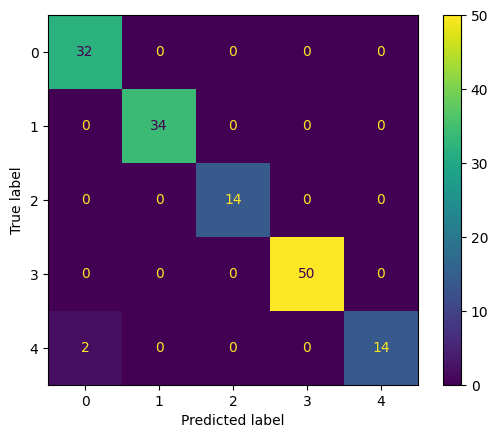

In [42]:
y_test_predict = np.argmax(model.predict(X_test), axis=1)  # Generate test set predictions
y_test_labels = np.where(y_test==1)[1]  # Convert y_test ohe back to numerical labels

y_test_pred_names = le.inverse_transform(y_test_predict)  # Convert numerical labels to user names
y_test_names = le.inverse_transform(y_test_labels)  # Convert numerical labels to user names

conf_matrix = confusion_matrix(y_test_names, y_test_pred_names, labels=['Ben', 'Eric', 'Oscar', 'Travis', 'Unknown'])
ConfusionMatrixDisplay(conf_matrix).plot()  # Plot confusion matrix

**6.4 ROC Curve**
Inspiration for the ROC curve display from the Sklearn documentation: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

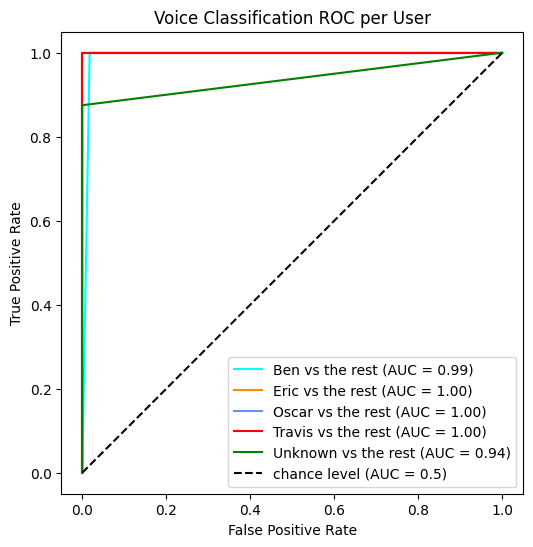

In [43]:
fig, ax = plt.subplots(figsize=(6, 6))

user_set = ['Ben', 'Eric', 'Oscar', 'Travis', 'Unknown']

colours = ["aqua", "darkorange", "cornflowerblue", "red", "green"]
for (user_label, colour) in zip(range(len(user_set)), colours):
    RocCurveDisplay.from_predictions(
        (y_test_labels == user_label).astype(int),
        (y_test_predict == user_label).astype(int),
        name = f"{user_set[user_label]} vs the rest",
        color=colour,
        ax=ax)


plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.axis('square')
plt.title("Voice Classification ROC per User")
plt.show()

**7. Save the Model**

In [44]:
model.save(os.path.abspath('../models/model_1'))

INFO:tensorflow:Assets written to: /home/travisdawson/Desktop/git_store/k_voice_assistant/models/model_1/assets
